In [42]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sps
from scipy import stats
import math 
import scipy
import statistics 
from scipy.integrate import quad
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import chi2, t, f, norm
import pandas as pd

## Задача Т1

In [2]:
N = 50
p = 6
coef = np.array([3, -2, 1, 1, -1])
data = np.array([np.random.uniform(low = -1.0, high = 1.0, size = 5) for i in range(N)])
target = np.array([np.random.normal(2 + np.sum(i * coef), 1.5) for i in data])

#### пункт а)

In [3]:
R_2_res = []
for i in range(5):
    psi = np.ones((N,1))
    psi = np.hstack([psi, np.delete(data, i, 1)])
    y = data[:,i]
    F = psi.T @ psi
    F_1 = np.linalg.inv(F)
    beta = F_1@psi.T @ y
    rss = (y-psi @ beta).T @ (y-psi @ beta)
    tss = np.sum((y-y.mean())**2) 
    R_2_res.append(1-rss/tss)
R_2_res

[0.1063667870083993,
 0.1952354479927848,
 0.25486439523010085,
 0.03799514817780103,
 0.06744289346541099]

##### не являются мультиколлинеарными

#### пункт b)

In [6]:
psi = np.ones((N,1))
psi = np.hstack([psi, data])

F = psi.T @ psi
F_1 = np.linalg.inv(F)
beta = F_1@psi.T @ target
rss = (target - psi @ beta).T @ (target-psi @ beta)
tss = np.sum((target-target.mean())**2) 

print("Коэффициенты - ")
for i in range(len(beta)):
    print(beta[i])

Коэффициенты - 
2.005629186981994
3.298071357025634
-1.6635951185887063
0.6264552943116686
0.9318336626882127
-1.2835316884737793


In [8]:
p_value_coef =  np.array([])
for i in range(len(beta)):
    delta = beta[i]/(np.sqrt(rss*F_1[i,i]))*np.sqrt(N-p)
    p_value_coef = np.append(p_value_coef, 2*t.sf(abs(delta), N-p))
    print(f"p-value for beta {i}: {2*t.sf(abs(delta), N-p)}")

p-value for beta 0: 5.313620440205256e-10
p-value for beta 1: 6.519272529667616e-08
p-value for beta 2: 0.0006496515157143047
p-value for beta 3: 0.2556447769483082
p-value for beta 4: 0.056339133633583185
p-value for beta 5: 0.00423651496810482


##### бета 5 больше 0.05, поэтому он является не значимым

#### пункт с)

In [9]:
R_2 = 1-rss/tss
print(f"Коэффициент детерминации (доля дисперсии, объясняемая регрессией) {R_2}")
delta_R_2 = R_2**2/(1-R_2**2)*(N-p)/(p-1)
print(f"p-value: {1- f.cdf(abs(delta_R_2), p-1, N-p)}")

Коэффициент детерминации (доля дисперсии, объясняемая регрессией) 0.7224817925331977
p-value: 2.991456023337946e-06


##### p-value < alfa => мы можем отвергать основную гипотезу о незначимости регрессии

#### пункт d)

In [13]:
psi_d = np.zeros_like(beta)
psi_d[0] = 1
y_d = np.sum(psi_d*beta)
print(f"прогноз: {y_d}")

for i in np.arange(2, 5, 0.0001):
    if abs(t.cdf(i, N-p) - 0.975)< 0.00001:
        print(f"{i:.4f}")
2.0152
2.0153
2.0154
2.0155
delta_d = 2.0154*np.sqrt(1+psi_d@F_1@psi_d.T)*np.sqrt(rss/(N-p)) 
print(f"Доверительный интервал: ({y_d-delta_d:.3f}, {y_d+delta_d:.3f})")

прогноз: 2.005629186981994
2.0152
2.0153
2.0154
2.0155
Доверительный интервал: (-1.540, 5.551)


#### пункт е)

In [14]:
error = target - psi@beta
I = 0
for i in range(1, len(error)):
    I += np.sum(error[i:] < error[i-1])

print(I)
delta_e = (I-N*(N-1)/4)/np.sqrt(N**3/36)
print(f"p-value: {2*(norm.sf(abs(delta_e), 0, 1))}")

627
p-value: 0.8056255996938094


##### p-val > 0.05 => отвергаем гипотезу о независимости ошибок

#### пункт f)

sigma = 1.6329948075470304


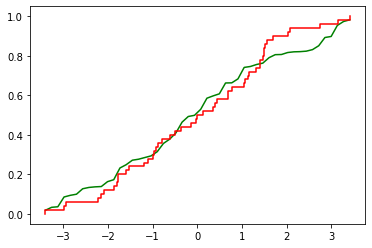

In [17]:
def ecdf(values):
    X_ = sorted(set(values))
    Y_ = [np.mean(values < x) for x in X_]
    X = sum([[v, v] for v in X_], [])
    Y = sum([[v, v] for v in Y_], [])
    Y = Y[1:]+[1]
    return X, Y


sigma = np.sqrt(error.var())  
print(f"sigma = {sigma}")


X_ecdf, Y_ecdf = ecdf(error)
Y_error = norm.cdf(np.sort(error), 0, sigma)
delta_f = np.sqrt(N)*(np.max(abs(Y_error.repeat(2)-Y_ecdf)))


plt.plot(np.linspace(min(error), max(error), N), Y_error, color = 'g')
plt.plot(X_ecdf, Y_ecdf, color = 'r')
plt.show()

In [20]:
delta_arr = np.array([])
for i in range(10000):
    error_i = np.random.normal(0, sigma, size = N)
    m_i, sigma_i = error_i.mean(), error_i.var() 
    Y_error_i = norm.cdf(np.sort(error_i), m_i, sigma_i)
    _, Y_ecdf_i = ecdf(error_i)
    delta_i = np.sqrt(N)*(np.max(abs(Y_error_i.repeat(2)-Y_ecdf_i)))
    delta_arr = np.append(delta_arr, delta_i)
delta_arr.sort()
print(delta_arr)

k_ = sum(delta_arr < delta_f)
k_ += 1

p_value_f = 1 - (k_ - 1)/10000
print(f"p_value Колмогорова и параметрического бутстрапа= {p_value_f}")

[0.4748342  0.48340755 0.48354553 ... 1.71965146 1.74239899 1.76215597]
p_value Колмогорова и параметрического бутстрапа= 0.9789


##### нет оснований отвергнуть гипотезу

#### пункт g)

In [22]:
sigma_g = np.median(abs(error))/0.675
print(f"sigma = {sigma_g}")
row_del = []
N_g = N

for i,e in enumerate(error):
    if e<=-2*sigma_g or e>=2*sigma_g:
        N_g -=1
        row_del.append(i)
        print(i,e)
        
        
data_g = np.delete(data, (row_del), axis=0)
target_g = np.delete(target, row_del)
psi_g = np.ones((N_g,1))
psi_g = np.hstack([psi_g, data_g])

F_g = psi_g.T @ psi_g
F_1_g = np.linalg.inv(F_g)
beta_g = F_1_g@psi_g.T @ target_g
rss_g = (target_g - psi_g @ beta_g).T @ (target_g-psi_g @ beta_g)
tss_g = np.sum((target_g-target_g.mean())**2) 
R_2_g = 1-rss_g/tss_g 
print(f"R2 до удаления выбросов: {R_2}, после: {R_2_g}")

sigma = 2.0196847359922963
R2 до удаления выбросов: 0.7224817925331977, после: 0.7224817925331977


#### пункт h)

In [23]:
CV_array = np.array([])
for i in range(N):
    data_h = np.delete(data, i, axis=0)
    target_h = np.delete(target, i)
    psi_h = np.ones((N-1, 1))
    psi_h = np.hstack([psi_h, data_h])
    
    F_h = psi_h.T @ psi_h
    F_1_h = np.linalg.inv(F_h)
    beta_h = F_1_h @ psi_h.T @ target_h
    CV_array = np.append(CV_array, (np.insert(data[i], 0, 1)@beta_h - target[i])**2)
R_cv = 1- np.sum(CV_array)/tss
R_cv

0.6414805005696576

#### пункт i)

In [24]:
k = 5
teta_arr = np.array([])
for i in range(k):
    teta_arr = np.append(teta_arr, np.random.normal(2+np.sum(coef*1), 1.5))
variance_5 = 1/(k-1)*np.sum((teta_arr - np.mean(teta_arr))**2)
delta_5 = rss/((N-p)*variance_5)
p_value_5 = f.sf(delta_5, N-p, k-1)
print(f"p_value: {p_value_5}")

p_value: 0.29919000936440465


##### нет оснований отвергнуть гипотезу о равенстве дисперсий

#### пункт j)

In [27]:

print(f"наименее значимый коэффициент = {p_value_coef.argmax()}")
data_j = np.delete(data, p_value_coef.argmax(), axis=1)
psi_j = np.ones((N,1))
psi_j = np.hstack([psi_j, data_j])

F_j = psi_j.T @ psi_j
F_1_j = np.linalg.inv(F_j)
beta_j = F_1_j@psi_j.T @ target
rss_j = (target - psi_j @ beta_j).T @ (target - psi_j @ beta_j)
tss_j = np.sum((target - target.mean())**2) 

print("Коэффициенты - ")
for i in range(len(beta_j)):
    print(beta_j[i])


наименее значимый коэффициент = 3
Коэффициенты - 
1.9820123331386847
3.251310995984098
-1.7091428023209099
0.7935554621331022
-1.236411072433179


In [29]:
p_value_coef_j =  np.array([])
for i in range(len(beta_j)):
    delta_j = beta_j[i]/(np.sqrt(rss_j*F_1_j[i,i]))*np.sqrt(N-p)
    p_value_coef_j = np.append(p_value_coef_j, 2*t.sf(abs(delta_j), N-p))
    print(f"p-value for feach {i}: {2*t.sf(abs(delta_j), N-p)}") #t.sf = 1-t.cdf, t.cdf - функция распределения(даёт значение)

print(f"коэффициент детерминации после удаления наименее значимого коэффициента {(tss_j-rss_j)/tss_j}")

p-value for feach 0: 2.049951400389533e-09
p-value for feach 1: 2.1146297561691433e-07
p-value for feach 2: 0.0007525621663076822
p-value for feach 3: 0.16362180047174846
p-value for feach 4: 0.007737569022449708
коэффициент детерминации после удаления наименее значимого коэффициента 0.6982501084844281


#### пункт k)

In [30]:
delta_k = (rss_j - rss)/rss*(N - p)/(p - (p-1)) 
def get_bootstrap_samples(data, target, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices], target[indices]
delta_k_arr = np.array([])

for i in range(1000):
    data_k, target_k = get_bootstrap_samples(data, target, 1)
    data_k, target_k = data_k[0], target_k[0]
    data_k_5 = np.delete(data_k, p_value_coef.argmax(), axis=1)
    
    psi_k = np.ones((N,1))
    psi_k_5 = np.hstack([psi_k, data_k_5])
    psi_k = np.hstack([psi_k, data_k]) 
    rss_k = (target_k - psi_k @ beta).T @ (target_k - psi_k @ beta)
    rss_k_5 = (target_k - psi_k_5 @ beta_j).T @ (target_k - psi_k_5 @ beta_j)
    delta_k_arr = np.append(delta_k_arr, (rss_k_5 - rss_k)/rss_k*(N - p)/(p - (p-1)))

    
delta_k_arr.sort()
k_k = sum(delta_k_arr < delta_k)
k_k += 1


In [32]:
p_value_k = 1 - (k_k - 1)/1000
print(f"p_value bootstrap = {p_value_k}")
print("p-val > 0.05 => нет оснований отвергнуть гипотезу")

p_value bootstrap = 0.509
p-val > 0.05 => нет оснований отвергнуть гипотезу


## Задача Т2

In [39]:
sample = [[83, 85], 
          [84, 85, 85, 86, 87], 
          [86, 87, 87, 87, 88, 88, 88, 88, 88, 89, 90],
          [89, 90, 90, 91],
          [90, 92]]

#### пункт а)

In [40]:
def TSS(y):
    y_average = sum(y)/len(y)
    res = 0
    for i in range(len(y)):
        res += (y[i] - y_average)**2
    return res

def RSS(e):
    return np.matmul(e.transpose(), e)

def R_2(tss, rss):
    return (tss - rss)/tss

def calc_koefs(ksi, y):
    ksi_T = ksi.transpose()
    F = np.matmul(ksi_T, ksi)
    F_inv = np.linalg.inv(F)
    koefs = np.matmul(F_inv, np.matmul(ksi_T, y))
    return koefs

def calc_e(ksi, y, koefs):
    return y - np.matmul(ksi, koefs)

ksi = []
y = []
for i in range(len(sample)):
    for j in range(len(sample[i])):
        line = [0]*len(sample)
        line[i] = 1
        ksi.append(line)
        y.append(sample[i][j])
n = len(ksi)
ksi = np.array(ksi)
y = np.array(y)

koefs = calc_koefs(ksi, y)

print('Коэффициенты: \n')
for i in range(len(koefs)):
    print(f'b{i} = {koefs[i]}')

Коэффициенты: 

b0 = 84.0
b1 = 85.4
b2 = 87.81818181818183
b3 = 90.0
b4 = 91.0


In [43]:
def calc_delta(ksi, koefs, i, rss):
    ksi_T = ksi.transpose()
    F = np.matmul(ksi_T, ksi)
    F_inv = np.linalg.inv(F)
    p = ksi.shape[1]
    return koefs[i]*math.sqrt(n-p)/math.sqrt(rss*F_inv[i][i])

def integrate_student(a, b, N):
    def student(x):
        return math.gamma((N+1)/2)/(math.sqrt(math.pi*N)*math.gamma(N/2)*(1+x**2/N)**((N+1)/2))
    return scipy.integrate.quad(student, a, b)[0]
    
e = calc_e(ksi, y, koefs)
rss = RSS(e)
    
deltas = [calc_delta(ksi, koefs, i, rss) for i in range(len(sample))]

p_values = [2*integrate_student(abs(deltas[i]), math.inf, n) for i in range(len(deltas))]
for i in range(len(sample)):
    if p_values[i] < 0.05:
        print(f'b{i} значим')
    else:
        print(f'b{i} не значим')

b0 значим
b1 значим
b2 значим
b3 значим
b4 значим


In [45]:
def integrate_fisher(a, b, d1, d2):
    def func(x):
        return x**(d1/2-1)*(1-x)**(d2/2-1)
    Beta = scipy.integrate.quad(func, 0, 1)[0]
    def fisher(x):
        return pow(d1/d2, d1/2) * pow(x, (d1/2 - 1)) * pow((1 + d1*x/d2), -(d1+d2)/2) / Beta 
    return scipy.integrate.quad(fisher, a, b)[0]


tss = TSS(y)
r_2 = R_2(tss, rss)
print('Коэффициент детерминации: R^2 =', r_2)

p = ksi.shape[1]
delta_r_2 = r_2*(n-p)/((1-r_2)*(p-1))

p_value_r_2 = integrate_fisher(delta_r_2, math.inf, p-1, n-p)
print('p-value =', p_value_r_2)
if p_value_r_2 < 0.05:
    print('Коэффициент детерминации значим')
else:
    print('Коэффициент детерминации не значим')

Коэффициент детерминации: R^2 = 0.8091004084734492
p-value = 1.2778798793544494e-06
Коэффициент детерминации значим


#### пункт b)

In [46]:
ksi_T = ksi.transpose()
F = np.matmul(ksi_T, ksi)
F_inv = np.linalg.inv(F)
for i in range(p):
    for j in range(i+1, p):
        delta_comp = (koefs[i]-koefs[j])*math.sqrt(n-p)/math.sqrt(rss*(F_inv[i][i]+F_inv[j][j]))
        p_value = 2*integrate_student(abs(delta_comp), math.inf, n-p)
        print(f'H0: b{i}=b{j} | H1: !H0     ->     p-value = {p_value} =>', end=' ')    

H0: b0=b1 | H1: !H0     ->     p-value = 0.14340811626585315 => H0: b0=b2 | H1: !H0     ->     p-value = 0.0002287219868382402 => H0: b0=b3 | H1: !H0     ->     p-value = 4.586693462926683e-06 => H0: b0=b4 | H1: !H0     ->     p-value = 4.003248689410462e-06 => H0: b1=b2 | H1: !H0     ->     p-value = 0.0006244964048529733 => H0: b1=b3 | H1: !H0     ->     p-value = 5.249414227098847e-06 => H0: b1=b4 | H1: !H0     ->     p-value = 7.186665224756283e-06 => H0: b2=b3 | H1: !H0     ->     p-value = 0.0029472837797510382 => H0: b2=b4 | H1: !H0     ->     p-value = 0.0012792424725151822 => H0: b3=b4 | H1: !H0     ->     p-value = 0.3054360645262756 => 